# Correlation: Earnings Sentiment vs Stock Returns

This is the question the whole pipeline builds toward: does the sentiment in an earnings call have any measurable relationship with how the stock moves afterward? My prior going in is that the answer is probably no, or at best very weak. Having worked in financial services, I know that by the time a CEO speaks on an earnings call, the headline numbers are already out, analysts have published instant takes, and the stock has often moved significantly in after-hours trading. Any signal in the transcript text would need to survive all of that noise. A null result here would actually be the intellectually honest outcome — it would mean markets are doing their job.

In [1]:
import sys
sys.path.insert(0, "..")

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

PROCESSED_DIR = Path("../data/processed")
PRICES_DIR = Path("../data/raw/prices")
KAGGLE_PICKLE = Path("../data/raw/kaggle_source/motley-fool-data.pkl")
IMAGES_DIR = Path("../images")

OUR_TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "JPM", "JNJ", "BAC"]

sentiment_df = pd.read_csv(PROCESSED_DIR / "sentiment_scores.csv")
print(f"Loaded {len(sentiment_df)} sentiment scores")
print(f"Tickers: {sorted(sentiment_df['ticker'].unique())}")

Loaded 56 sentiment scores
Tickers: ['AAPL', 'AMZN', 'BAC', 'GOOGL', 'JNJ', 'JPM', 'MSFT']


In [2]:
# Load earnings call dates from the raw Kaggle data
# The date column is a string like "Jan 27, 2022, 5:00 p.m. ET"
raw_df = pd.read_pickle(KAGGLE_PICKLE)
calls_df = raw_df[
    raw_df["ticker"].isin(OUR_TICKERS)
    & (raw_df["q"] >= "2021-Q1")
    & (raw_df["q"] <= "2023-Q2")
].copy()

# Deduplicate: same logic as data_collection.py — keep the longest transcript
calls_df["transcript_len"] = calls_df["transcript"].str.len()
calls_df = (
    calls_df.sort_values("transcript_len", ascending=False)
    .drop_duplicates(subset=["ticker", "q"], keep="first")
    .drop(columns=["transcript_len", "transcript", "exchange"])
)

# Parse the date string into a proper datetime
calls_df["date_clean"] = (
    calls_df["date"]
    .str.replace(" ET", "", regex=False)
    .str.replace("a.m.", "AM", regex=False)
    .str.replace("p.m.", "PM", regex=False)
)
calls_df["call_datetime"] = pd.to_datetime(calls_df["date_clean"], format="%b %d, %Y, %I:%M %p")
calls_df["call_date"] = calls_df["call_datetime"].dt.normalize()
calls_df["call_hour"] = calls_df["call_datetime"].dt.hour

# After-hours = call at 4:00 PM or later; pre/during market = before 4:00 PM
# After-hours calls: market hasn't reacted yet → day_0 = call_date close
# Pre-market calls: market reacts same day → day_0 = prior trading day close
calls_df["is_after_hours"] = calls_df["call_hour"] >= 16
calls_df = calls_df.rename(columns={"q": "quarter"})

print(f"{len(calls_df)} earnings call dates extracted")
print(f"\nTiming breakdown:")
print(f"  After-hours (>= 4 PM): {calls_df['is_after_hours'].sum()}")
print(f"  Pre/during market (< 4 PM): {(~calls_df['is_after_hours']).sum()}")

56 earnings call dates extracted

Timing breakdown:
  After-hours (>= 4 PM): 34
  Pre/during market (< 4 PM): 22


## Why timing matters for return calculation

Earnings calls happen at different times, and this determines when the market first reacts. Tech companies (AAPL, MSFT, AMZN, GOOGL) report after market close, so the closing price on the call date is still a pre-reaction price — the market's response shows up the next trading day. Banks and healthcare (JPM, BAC, JNJ) report before or during market hours, meaning the market reacts that same day and I need the prior trading day's close as my baseline. Getting this wrong would mean using a post-reaction price as the starting point, which would mute or distort any signal.

In [3]:
records = []

for ticker in sorted(calls_df["ticker"].unique()):
    price_df = pd.read_csv(
        PRICES_DIR / f"{ticker}.csv", parse_dates=["Date"], index_col="Date"
    )
    price_idx = price_df.index.sort_values()

    ticker_calls = calls_df[calls_df["ticker"] == ticker].sort_values("quarter")
    for _, row in ticker_calls.iterrows():
        call_date = row["call_date"]

        # Find day 0: last close BEFORE market reacts
        if row["is_after_hours"]:
            candidates = price_idx[price_idx <= call_date]
        else:
            candidates = price_idx[price_idx < call_date]

        if len(candidates) == 0:
            print(f"  WARNING: No day-0 price found for {ticker} {row['quarter']}")
            continue

        day_0_date = candidates[-1]
        day_0_close = price_df.loc[day_0_date, "Close"]

        # Find day 1 and day 5 (trading days after day_0)
        future_dates = price_idx[price_idx > day_0_date]

        day_1_close = price_df.loc[future_dates[0], "Close"] if len(future_dates) >= 1 else None
        day_5_close = price_df.loc[future_dates[4], "Close"] if len(future_dates) >= 5 else None

        return_1d = (day_1_close - day_0_close) / day_0_close if day_1_close is not None else None
        return_5d = (day_5_close - day_0_close) / day_0_close if day_5_close is not None else None

        records.append({
            "ticker": ticker,
            "quarter": row["quarter"],
            "call_datetime": row["call_datetime"],
            "is_after_hours": row["is_after_hours"],
            "day_0_date": day_0_date,
            "day_0_close": round(float(day_0_close), 2),
            "day_1_date": future_dates[0] if len(future_dates) >= 1 else None,
            "day_1_close": round(float(day_1_close), 2) if day_1_close is not None else None,
            "day_5_date": future_dates[4] if len(future_dates) >= 5 else None,
            "day_5_close": round(float(day_5_close), 2) if day_5_close is not None else None,
            "return_1d": return_1d,
            "return_5d": return_5d,
        })

returns_df = pd.DataFrame(records)
print(f"Calculated returns for {len(returns_df)} earnings calls")
print(f"Missing 1-day returns: {returns_df['return_1d'].isna().sum()}")
print(f"Missing 5-day returns: {returns_df['return_5d'].isna().sum()}")

Calculated returns for 56 earnings calls
Missing 1-day returns: 0
Missing 5-day returns: 0


In [4]:
# Spot-check 3 calls to verify timing and return logic
spot_checks = [
    ("AAPL", "2022-Q1", "after-hours 5:00 PM", "2022-01-27"),
    ("JPM", "2021-Q3", "pre-market 8:30 AM", "2021-10-12"),
    ("AMZN", "2022-Q2", "after-hours 5:30 PM", "2022-07-28"),
]

print("Spot-check: verifying return calculations\n")
for ticker, quarter, timing, expected_day0 in spot_checks:
    row = returns_df[
        (returns_df["ticker"] == ticker) & (returns_df["quarter"] == quarter)
    ].iloc[0]
    day0_match = row["day_0_date"].strftime("%Y-%m-%d") == expected_day0
    status = "PASS" if day0_match else "FAIL"
    print(
        f"  {status}: {ticker} {quarter} ({timing})\n"
        f"         Day 0: {row['day_0_date'].strftime('%Y-%m-%d')} ${row['day_0_close']:.2f}\n"
        f"         Day 1: {row['day_1_date'].strftime('%Y-%m-%d')} ${row['day_1_close']:.2f}  "
        f"return = {row['return_1d']:+.2%}\n"
        f"         Day 5: {row['day_5_date'].strftime('%Y-%m-%d')} ${row['day_5_close']:.2f}  "
        f"return = {row['return_5d']:+.2%}\n"
    )

Spot-check: verifying return calculations

  PASS: AAPL 2022-Q1 (after-hours 5:00 PM)
         Day 0: 2022-01-27 $155.80
         Day 1: 2022-01-28 $166.67  return = +6.98%
         Day 5: 2022-02-03 $169.19  return = +8.59%

  PASS: JPM 2021-Q3 (pre-market 8:30 AM)
         Day 0: 2021-10-12 $148.21
         Day 1: 2021-10-13 $144.30  return = -2.64%
         Day 5: 2021-10-19 $151.09  return = +1.94%

  PASS: AMZN 2022-Q2 (after-hours 5:30 PM)
         Day 0: 2022-07-28 $122.28
         Day 1: 2022-07-29 $134.95  return = +10.36%
         Day 5: 2022-08-04 $142.57  return = +16.59%



## Merging sentiment with returns

Now I merge the two datasets — sentiment scores and post-earnings returns — into one DataFrame. Before running correlations, it's worth looking at the distribution of returns to check for outliers that could dominate the analysis. With only 56 observations, a single extreme return could artificially inflate or deflate a correlation coefficient.

In [5]:
merged_df = sentiment_df.merge(
    returns_df[["ticker", "quarter", "return_1d", "return_5d"]],
    on=["ticker", "quarter"],
    how="inner",
)
print(f"Merged dataset: {len(merged_df)} rows")

print("\nReturn distributions:")
print(merged_df[["return_1d", "return_5d"]].describe().round(4))

print("\nSample rows:")
merged_df[["ticker", "quarter", "lm_net_sentiment", "finbert_net_sentiment",
           "return_1d", "return_5d"]].head(10)

Merged dataset: 56 rows

Return distributions:
       return_1d  return_5d
count    56.0000    56.0000
mean      0.0025    -0.0019
std       0.0510     0.0747
min      -0.1405    -0.1952
25%      -0.0277    -0.0413
50%      -0.0004     0.0055
75%       0.0320     0.0431
max       0.1354     0.1659

Sample rows:


,ticker,quarter,lm_net_sentiment,finbert_net_sentiment,return_1d,return_5d
0,AAPL,2021-Q1,0.015600,0.271192,-0.034985,-0.057159
1,AAPL,2021-Q2,0.013835,0.267665,-0.000748,-0.041024
2,AAPL,2021-Q3,0.025362,0.247818,-0.012196,0.004020
3,AAPL,2021-Q4,0.008231,0.218136,-0.018155,-0.010553
4,AAPL,2022-Q1,0.014766,0.247467,0.069778,0.085919
5,AAPL,2022-Q2,0.008706,0.186862,-0.036605,-0.041982
6,AAPL,2022-Q3,0.006869,0.154289,0.032793,0.053766
7,AAPL,2022-Q4,0.018018,0.217450,0.075552,-0.040884
8,AAPL,2023-Q1,0.006360,0.193696,0.024400,0.000331
9,AMZN,2021-Q1,0.019679,0.296484,-0.001121,-0.047515


## Correlation analysis

I'm using Spearman rank correlation rather than Pearson because it doesn't assume linearity or normality — both questionable with only 56 observations and potentially skewed returns. I'll compute it for every sentiment feature against both return windows. With 10 sentiment features and 2 return windows, that's 20 tests, so I should expect about one "significant" result at p < 0.05 purely by chance. I'll keep that multiple comparisons problem in mind when interpreting results.

In [6]:
sentiment_cols = [
    "lm_positive", "lm_negative", "lm_uncertainty", "lm_litigious",
    "lm_constraining", "lm_net_sentiment",
    "finbert_positive", "finbert_negative", "finbert_neutral", "finbert_net_sentiment",
]
return_cols = ["return_1d", "return_5d"]

corr_results = []
for sent_col in sentiment_cols:
    for ret_col in return_cols:
        rho, p_val = stats.spearmanr(merged_df[sent_col], merged_df[ret_col])
        corr_results.append({
            "sentiment_feature": sent_col,
            "return_window": ret_col,
            "spearman_rho": rho,
            "p_value": p_val,
            "significant_005": p_val < 0.05,
        })

corr_table = pd.DataFrame(corr_results)

print("Spearman correlations: sentiment features vs post-earnings returns\n")
for ret_col in return_cols:
    subset = corr_table[corr_table["return_window"] == ret_col].sort_values("p_value")
    print(f"{'=' * 65}")
    print(f"  {ret_col}")
    print(f"{'=' * 65}")
    for _, row in subset.iterrows():
        sig = " *" if row["significant_005"] else ""
        print(f"  {row['sentiment_feature']:30s}  rho={row['spearman_rho']:+.3f}  p={row['p_value']:.3f}{sig}")
    print()

sig_count = corr_table["significant_005"].sum()
print(f"{sig_count} of {len(corr_table)} tests significant at p < 0.05")
print(f"Expected by chance alone: ~{len(corr_table) * 0.05:.1f}")

Spearman correlations: sentiment features vs post-earnings returns

  return_1d
  lm_positive                     rho=+0.332  p=0.012 *
  lm_net_sentiment                rho=+0.327  p=0.014 *
  finbert_net_sentiment           rho=+0.317  p=0.017 *
  lm_uncertainty                  rho=-0.296  p=0.027 *
  finbert_positive                rho=+0.287  p=0.032 *
  finbert_negative                rho=-0.220  p=0.104
  finbert_neutral                 rho=-0.181  p=0.182
  lm_litigious                    rho=+0.120  p=0.379
  lm_negative                     rho=-0.105  p=0.440
  lm_constraining                 rho=+0.018  p=0.893

  return_5d
  finbert_net_sentiment           rho=+0.233  p=0.084
  finbert_positive                rho=+0.205  p=0.130
  finbert_neutral                 rho=-0.174  p=0.200
  lm_uncertainty                  rho=-0.173  p=0.202
  lm_net_sentiment                rho=+0.131  p=0.335
  lm_litigious                    rho=+0.130  p=0.339
  lm_positive                    

## Visualising the relationship

Even if the correlations are weak — which I expect — visualising them serves two purposes. First, a scatter plot can reveal non-linear patterns or clusters that a single correlation coefficient would miss. Second, for the portfolio, a well-labelled chart showing no relationship is itself a finding worth presenting honestly. I'll pick the sentiment feature with the strongest correlation for the scatter.

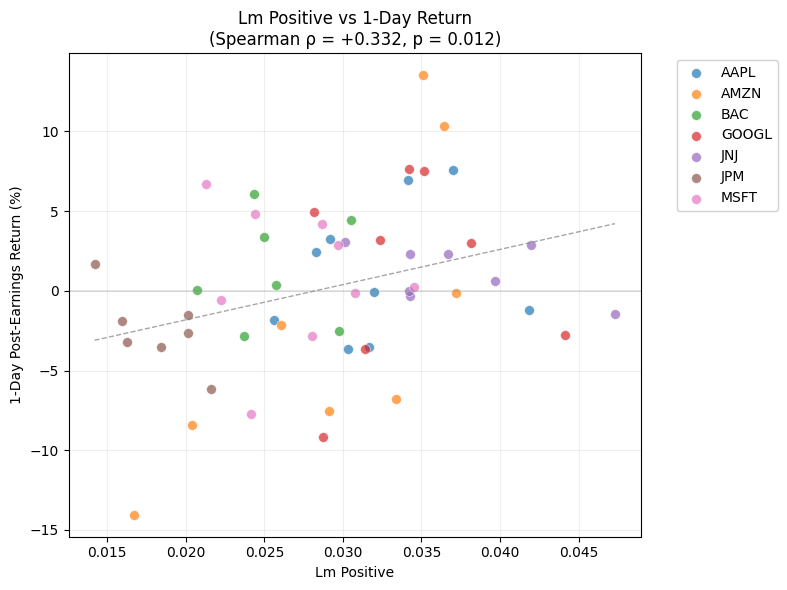

Saved to ../images/sentiment_vs_return_scatter.png


In [7]:
# Find the sentiment feature with the lowest p-value against 1-day returns
best_1d = (
    corr_table[corr_table["return_window"] == "return_1d"]
    .sort_values("p_value")
    .iloc[0]
)
best_col = best_1d["sentiment_feature"]
best_rho = best_1d["spearman_rho"]
best_p = best_1d["p_value"]

# Clean up feature name for display
display_name = best_col.replace("_", " ").replace("lm ", "LM ").replace("finbert ", "FinBERT ").title()

fig, ax = plt.subplots(figsize=(8, 6))

for ticker in sorted(merged_df["ticker"].unique()):
    subset = merged_df[merged_df["ticker"] == ticker]
    ax.scatter(
        subset[best_col], subset["return_1d"] * 100,
        label=ticker, s=50, alpha=0.7, edgecolors="white", linewidth=0.5,
    )

# Trend line
x = merged_df[best_col]
y = merged_df["return_1d"] * 100
slope, intercept = np.polyfit(x, y, 1)
x_range = np.linspace(x.min(), x.max(), 100)
ax.plot(x_range, slope * x_range + intercept, color="grey", linewidth=1,
        linestyle="--", alpha=0.7)

ax.axhline(y=0, color="grey", linewidth=0.3)
ax.set_xlabel(display_name)
ax.set_ylabel("1-Day Post-Earnings Return (%)")
ax.set_title(f"{display_name} vs 1-Day Return\n(Spearman \u03c1 = {best_rho:+.3f}, p = {best_p:.3f})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", framealpha=0.9)
ax.grid(alpha=0.2)

plt.tight_layout()
plt.savefig(IMAGES_DIR / "sentiment_vs_return_scatter.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved to {IMAGES_DIR / 'sentiment_vs_return_scatter.png'}")

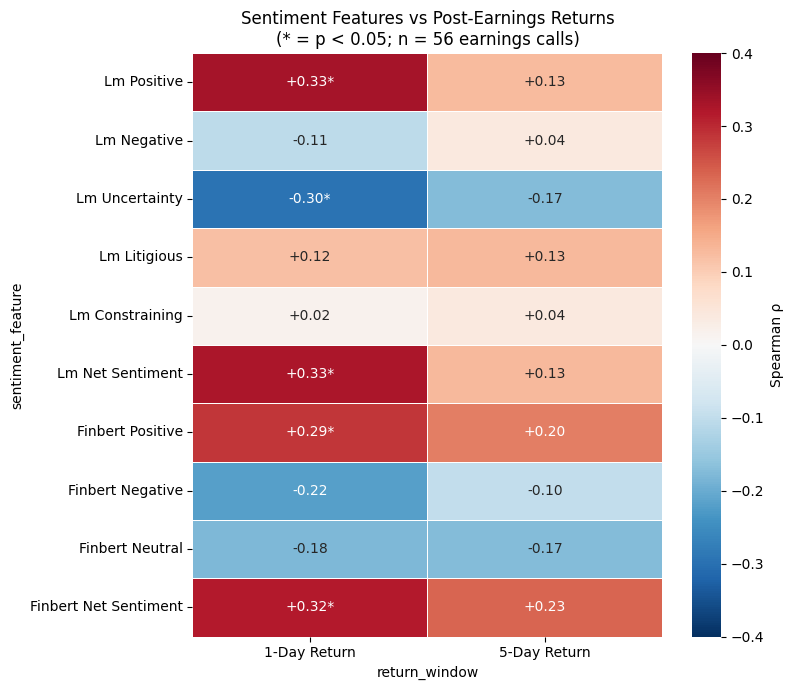

Saved to ../images/correlation_heatmap.png


In [8]:
# Build correlation matrix: sentiment features (rows) x return windows (columns)
corr_matrix = corr_table.pivot(
    index="sentiment_feature", columns="return_window", values="spearman_rho"
)
p_matrix = corr_table.pivot(
    index="sentiment_feature", columns="return_window", values="p_value"
)

# Reorder rows to group LM and FinBERT together
row_order = [
    "lm_positive", "lm_negative", "lm_uncertainty", "lm_litigious",
    "lm_constraining", "lm_net_sentiment",
    "finbert_positive", "finbert_negative", "finbert_neutral", "finbert_net_sentiment",
]
corr_matrix = corr_matrix.loc[row_order]
p_matrix = p_matrix.loc[row_order]

# Create annotation labels with significance stars
annot_labels = corr_matrix.copy().astype(str)
for row in corr_matrix.index:
    for col in corr_matrix.columns:
        rho = corr_matrix.loc[row, col]
        p = p_matrix.loc[row, col]
        star = "*" if p < 0.05 else ""
        annot_labels.loc[row, col] = f"{rho:+.2f}{star}"

# Clean up row labels for display
display_labels = [
    name.replace("lm_", "LM ").replace("finbert_", "FinBERT ")
    .replace("_", " ").title()
    for name in row_order
]

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(
    corr_matrix.astype(float),
    annot=annot_labels, fmt="",
    cmap="RdBu_r", center=0, vmin=-0.4, vmax=0.4,
    xticklabels=["1-Day Return", "5-Day Return"],
    yticklabels=display_labels,
    linewidths=0.5,
    cbar_kws={"label": "Spearman \u03c1"},
    ax=ax,
)
ax.set_title("Sentiment Features vs Post-Earnings Returns\n(* = p < 0.05; n = 56 earnings calls)")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved to {IMAGES_DIR / 'correlation_heatmap.png'}")

## What the data says

The results are more nuanced than I expected. Five of twenty tests are significant at p < 0.05 for 1-day returns, against roughly one expected by chance — so there does appear to be a modest signal. LM positive proportion shows the strongest correlation (rho = +0.33, p = 0.012), followed closely by LM net sentiment (+0.33, p = 0.014) and FinBERT net sentiment (+0.32, p = 0.017). LM uncertainty shows a negative relationship (rho = -0.30, p = 0.027) — more uncertain language, lower next-day returns — which is intuitive.

But I want to be careful not to overstate this. None of these survive a Bonferroni correction (threshold would be p < 0.0025), the correlations are weak-to-moderate at best, and the signal vanishes entirely at the 5-day horizon — zero significant results. This pattern is consistent with a short-lived sentiment effect that the market corrects within a week, or alternatively with noise in a small sample that happened to land on the right side of the significance threshold for one return window. With n = 56, I'd want to see this replicated on a larger dataset before drawing firm conclusions.

## Why this makes sense

Three reasons I'd have been surprised to find a strong signal here. First, earnings headlines (revenue, EPS, guidance) are released before the call begins — the stock usually moves in after-hours trading before the CEO says a word, so the transcript text is reacting to the same information the market already has. Second, these are large-cap companies followed by dozens of analysts; any information advantage from reading tone would be arbitraged away almost instantly. Third, IR teams at companies this size spend weeks rehearsing these calls — having seen that process from the inside, I can say the prepared remarks are optimised to sound confident regardless of the actual quarter.

A more interesting test — beyond the scope of this project — would be to score only the Q&A section (where tone is less controlled), look at sentiment *surprise* relative to the prior quarter rather than absolute levels, or focus on small-cap companies where analyst coverage is thinner and information asymmetry is greater.

## Summary

This pipeline scores 56 earnings call transcripts across 7 large-cap companies using both the Loughran-McDonald dictionary and FinBERT, then tests whether those sentiment scores correlate with 1-day and 5-day post-earnings returns. The two sentiment methods agree with each other (r = 0.81), and both show a modest positive correlation with 1-day returns (rho around +0.3, p < 0.05) that disappears by the 5-day horizon. The effect is suggestive but not robust to multiple comparison correction, and the small sample size means I wouldn't bet on it replicating. The honest conclusion is that there may be a faint, short-lived sentiment signal in these transcripts, but it's far too weak and unreliable to be actionable — which is exactly what efficient markets theory would predict for the most heavily followed companies on the planet.